In [1]:
import os
import gc
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import anndata as ad
import numpy as np
import yaml
import sys
import h5py
import logging
import scanpy as sc
from os.path import join
import scipy.io as sio
import scipy.sparse as sps
from sklearn.cluster import KMeans
import gzip
from scipy.io import mmread
from pathlib import Path, PurePath
from sklearn.metrics import adjusted_rand_score


import warnings
def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

from sklearn.metrics import adjusted_rand_score

def split_ob(ads, ad_ref, ob='obs', key='emb2'):
    len_ads = [_.n_obs for _ in ads]
    if ob=='obsm':
        split_obsms = np.split(ad_ref.obsm[key], np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obsms):
            ad.obsm[key] = v
    else:
        split_obs = np.split(ad_ref.obs[key].to_list(), np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obs):
            ad.obs[key] = v

def eval_ads(ads, ref_key, src_key, exclude=[]):
    aris = []
    for ad in ads:
        _mask = ~ad.obs[ref_key].isin(exclude)
        gt = ad.obs[ref_key].values[_mask]
        pred = ad.obs[src_key].values[_mask]
        aris.append(adjusted_rand_score(pred, gt))
    return aris

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
def search_louvain(ad, use_rep, n_neighbors=15, n_clusters=5):
    sc.pp.neighbors(ad, n_neighbors=n_neighbors, use_rep=use_rep)
    rs = np.arange(0.1, 1.0, 0.1)
    n_cs = []
    for r in rs:
        sc.tl.louvain(ad, resolution=r, key_added=f'r={r}')
        n_cs.append(ad.obs[f'r={r}'].nunique())
    n_cs = np.array(n_cs)
    if (n_cs==n_clusters).sum() >= 1:
        ri = np.where(n_cs==n_clusters)[0][0]
        ad.obs['louvain_k'] = ad.obs[f'r={rs[ri]}'].to_list()
    else:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(ad.obsm[use_rep])
        ad.obs['louvain_k'] = kmeans.labels_.astype('str')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
def eval_labelTransfer(ad1, ad2, use_rep, lab_key, knn=10):
     with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        neigh1 = KNeighborsClassifier(n_neighbors=knn)
        neigh1.fit(ad1.obsm[use_rep], ad1.obs[lab_key].to_list())
        pr_lab2 = neigh1.predict(ad2.obsm[use_rep])
        f1_1 = f1_score(ad2.obs[lab_key].values, pr_lab2, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        # acc1 = (pr_lab2 == ad2.obs[lab_key].values).mean()
    
        neigh2 = KNeighborsClassifier(n_neighbors=knn)
        neigh2.fit(ad2.obsm[use_rep], ad2.obs[lab_key].to_list())
        pr_lab1 = neigh2.predict(ad1.obsm[use_rep])
        # acc2 = (pr_lab1 == ad1.obs[lab_key].values).mean()
        f1_2 = f1_score(ad1.obs[lab_key].values, pr_lab1, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        return (f1_1+f1_2)/2

from scib.metrics import lisi
def eval_lisi(
        adata,
        batch_keys=['domain', 'batch'],
        label_keys = ['gt'],
        use_rep='X_emb', use_neighbors=False,
    ):
    res = {}
    for key in batch_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.ilisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_iLISI'] = _lisi
    for key in label_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.clisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            batch_key=None,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_cLISI'] = _lisi
    df = pd.DataFrame.from_dict(res, orient='index').T
    # df.columns = [_+'_LISI' for _ in df.columns]
    return df

os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

def load_data(_dir):
    feat_names = pd.read_csv(join(_dir, 'features.tsv.gz'), compression='gzip', sep='\t', header=None)
    barcodes   = pd.read_csv(join(_dir, 'barcodes.tsv.gz'), compression='gzip', sep='\t', header=None)

    with gzip.open(join(_dir, 'matrix.mtx.gz'), 'rb') as gzipped_file:
        mat = mmread(gzipped_file)

    ad = sc.AnnData(sps.csr_matrix(mat.T))
    ad.obs_names = barcodes[0].values
    ad.var_names = feat_names[0].values
    ad.var['name'] = feat_names[1].values
    ad.var['type'] = feat_names[2].values
    return ad

import json
import copy
from matplotlib.image import imread
def flip_coords(ads):
    for ad in ads:
        ad.obsm['spatial'] = -1 * ad.obsm['spatial']
        ad.obsm['spatial'] = ad.obsm['spatial'][:, ::-1]

def reorder(ad1, ad2):
    shared_barcodes = ad1.obs_names.intersection(ad2.obs_names)
    ad1 = ad1[shared_barcodes].copy()
    ad2 = ad2[shared_barcodes].copy()
    return ad1, ad2

def load_peak_expr(_dir):
    data = sio.mmread(join(_dir, 'data.mtx'))
    cname = pd.read_csv(join(_dir, 'barcode.csv'), index_col=0)['x'].to_list()
    feat = pd.read_csv(join(_dir, 'feat.csv'), index_col=0)['x'].to_list()
    ad = sc.AnnData(sps.csr_matrix(data.T))
    ad.obs_names = cname
    ad.var_names = feat
    return ad

In [2]:
def set_col2cat(ad, cols=[]):
    for col in cols:
        ad.obs[col] = ad.obs[col].astype('category')

def unify_colors(queries, color_key, ref_color_dict):
    for q in queries:
        q.obs[color_key] = q.obs[color_key].astype('category')
        q.uns[f'{color_key}_colors'] = [ref_color_dict[_] for _ in q.obs[color_key].cat.categories]
    return queries

def subset_ad(ad, subset_index):
    ad = ad[subset_index].copy()
    return ad

def set_spatial(ad):
    ad.obsm['spatial'] = ad.obs[['array_row', 'array_col']].values
    ad.obsm['spatial'] = ad.obsm['spatial'][:, ::-1]
    ad.obsm['spatial'][:, 1] = -1 * ad.obsm['spatial'][:, 1]
    return ad

In [3]:
from collections import Counter
def load_zu(_dir):
    zs = []

    for fi in sorted(os.listdir(_dir)):
        dfi = pd.read_csv(join(_dir, fi), header=None)
        zs.append(dfi.values)
    zs = np.vstack(zs)
    z, u = zs[:, :-2], zs[:, -2:]
    return z, u

def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

In [4]:
result_dir = '/disco_500t/xuhua/gitrepo/midas/result'

In [5]:
data_dir = '/disco_500t/xuhua/data/real_mosaic_cases/mouse_brain_rna+H3K27ac/rna+atac'

df_rep1_rna = pd.read_csv(join(data_dir, 'GSM6204635_MouseBrain_20um_H3K27ac_matrix.tsv'), sep='\t')
df_rep1_spatial = pd.read_csv(join(data_dir, 'GSM6204621_spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_rep1_rna = sc.AnnData(df_rep1_rna.T, obsm={'spatial': df_rep1_spatial.loc[df_rep1_rna.columns, [2, 3]].values})
ad_rep1_rna.obs['src'] = ['s1']*ad_rep1_rna.n_obs

ad_rep1_atac = load_peak_expr(join(data_dir, 'peak_data_3slices/GSM6204621_peak_data'))
ad_rep1_atac.obs['src'] = ['s1']*ad_rep1_atac.n_obs
ad_rep1_atac.obsm['spatial'] = df_rep1_spatial.loc[ad_rep1_atac.obs_names, [2, 3]].values
ad_rep1_rna, ad_rep1_atac = reorder(ad_rep1_rna, ad_rep1_atac)

df_rep2_rna = pd.read_csv(join(data_dir, 'GSM6753042_MouseBrain_20um_repH3K27ac_matrix.tsv'), sep='\t')
df_rep2_spatial = pd.read_csv(join(data_dir, 'GSM6753042_spatial/tissue_positions_list.csv'), header=None, index_col=0)
ad_rep2_rna = sc.AnnData(df_rep2_rna.T, obsm={'spatial': df_rep2_spatial.loc[df_rep2_rna.columns, [2, 3]].values})
ad_rep2_rna.obs['src'] = ['s2-rna']*ad_rep2_rna.n_obs

ad_rep2_atac = load_peak_expr(join(data_dir, 'peak_data_3slices/GSM6753042_peak_data'))
ad_rep2_atac.obs['src'] = ['s2-atac']*ad_rep2_atac.n_obs
ad_rep2_atac.obsm['spatial'] = df_rep2_spatial.loc[ad_rep2_atac.obs_names, [2, 3]].values
ad_rep2_rna, ad_rep2_atac = reorder(ad_rep2_rna, ad_rep2_atac)

shared_gene = ad_rep1_rna.var_names.intersection(ad_rep2_rna.var_names)
ad_rep1_rna = ad_rep1_rna[:, shared_gene].copy()
ad_rep2_rna = ad_rep2_rna[:, shared_gene].copy()

shared_peak = ad_rep1_atac.var_names.intersection(ad_rep2_atac.var_names)
ad_rep1_atac = ad_rep1_atac[:, shared_peak].copy()
ad_rep2_atac = ad_rep2_atac[:, shared_peak].copy()

ad_rep1_rna.obs_names = [f's1-{x}' for x in ad_rep1_rna.obs_names]
ad_rep1_atac.obs_names = [f's1-{x}' for x in ad_rep1_atac.obs_names]
ad_rep2_rna.obs_names = [f's2-rna-{x}' for x in ad_rep2_rna.obs_names]
ad_rep2_atac.obs_names = [f's2-atac-{x}' for x in ad_rep2_atac.obs_names]

ad_rep1_rna.obsm['spatial'][:, 0] = -1 * ad_rep1_rna.obsm['spatial'][:, 0]
ad_rep2_rna.obsm['spatial'] = -1 * ad_rep2_rna.obsm['spatial']
ad_rep1_atac.obsm['spatial'][:, 0] = -1 * ad_rep1_atac.obsm['spatial'][:, 0]
ad_rep2_atac.obsm['spatial'] = -1 * ad_rep2_atac.obsm['spatial']

ad_rep2_rna.obs['Sample'] = ['S2']*ad_rep2_rna.n_obs
ad_rep2_atac.obs['Sample'] = ['S2']*ad_rep2_atac.n_obs

In [6]:
ad_mult_rna = ad_rep1_rna
ad_mult_atac = ad_rep1_atac
ad_rna = ad_rep2_rna
ad_atac = ad_rep2_atac

In [7]:
ad_rna_all = sc.concat([ad_mult_rna, ad_rna])
ad_atac_all = sc.concat([ad_mult_atac, ad_atac])

sc.pp.highly_variable_genes(ad_rna_all, flavor='seurat_v3', n_top_genes=10000, batch_key='src')
hvg_names = ad_rna_all.var.query('highly_variable').index.to_numpy()

# ac.pp.tfidf(ad_atac_all, scale_factor=1e4)
sc.pp.highly_variable_genes(ad_atac_all, flavor='seurat_v3', n_top_genes=100000, batch_key='src')
hvp_names = ad_atac_all.var.query('highly_variable').index.to_numpy()

In [8]:
ad_mult_rna = ad_mult_rna[:, hvg_names].copy()
ad_rna = ad_rna[:, hvg_names].copy()
ad_mult_atac = ad_mult_atac[:, hvp_names].copy()
ad_atac = ad_atac[:, hvp_names].copy()

In [9]:
## filter feat names
filtered_atac_feats = [_ for _ in ad_atac.var_names if _.startswith('chr')]
ad_atac = ad_atac[:, filtered_atac_feats].copy()
ad_mult_atac = ad_mult_atac[:, filtered_atac_feats].copy()

In [10]:
def split_list_byChr(input_list):
    atac_name_chunks = []
    for n in input_list:
        chr = n.split("-")[0]
        if len(atac_name_chunks) == 0 or chr!=atac_name_chunks[-1]:
            atac_name_chunks.append(chr)
    return atac_name_chunks

In [11]:
### save data
input_train_mod1 = ad_mult_rna
input_train_mod2 = ad_mult_atac
input_test_mod1 = ad_rna
input_test_mod2 = ad_atac

tmp_out_dir = f'/disco_500t/xuhua/gitrepo/midas/data/processed/MB_RNA_H3K27ac_modalMatch'
feat_dir = join(tmp_out_dir, 'feat')
os.makedirs(feat_dir, exist_ok=True)

atac_feat_chunks = split_list_byChr(input_train_mod2.var_names) # split the chr-? in order

atac_chr_count = Counter([_.split('-')[0] for _ in ad_atac.var_names]) # count the frequency of each chr-?
df_feat_dims = pd.DataFrame(np.array([atac_chr_count[_] for _ in atac_feat_chunks]).reshape(-1, 1), columns=['atac'])
df_feat_dims['rna'] = input_train_mod1.n_vars
df_feat_rna_names = pd.DataFrame(input_train_mod1.var_names, columns=['x'])
df_feat_adt_names = pd.DataFrame(input_train_mod2.var_names, columns=['x'])
df_feat_dims.to_csv(join(feat_dir, 'feat_dims.csv'))
df_feat_rna_names.to_csv(join(feat_dir, 'feat_names_rna.csv'))
df_feat_adt_names.to_csv(join(feat_dir, 'feat_names_atac.csv'))

In [12]:
# each subset
subsets = [[input_train_mod1, input_train_mod2], [input_test_mod1], [input_test_mod2]]
mods = [['rna', 'atac'], ['rna'], ['atac']]

for si in range(3):
    for fname in ['mask', 'mat', 'vec']:
        os.makedirs(join(tmp_out_dir, f'subset_{si}/{fname}'), exist_ok=True)
    tmp_dir = join(tmp_out_dir, f'subset_{si}')
    for ad,mi in zip(subsets[si], mods[si]):
        mat = ad.X.A if sps.issparse(ad.X) else ad.X
        df_mat = pd.DataFrame(mat, index=ad.obs_names, columns=ad.var_names)
        df_mat.to_csv(join(tmp_dir, f'mat/{mi}.csv'))

        os.makedirs(join(tmp_dir, f'vec/{mi}'), exist_ok=True)
        for idx, mati in enumerate(mat):
            pd.DataFrame(mati.reshape(1, -1)).to_csv(join(tmp_dir, 'vec/{}/{:05d}.csv'.format(mi, idx)), header=None, index=None)
        pd.DataFrame(ad.obs_names, columns=['x']).to_csv(join(tmp_dir, 'cell_names.csv'))

        # save mask
        pd.DataFrame(np.ones(ad.n_vars, dtype='int')).to_csv(join(tmp_dir, f'mask/{mi}.csv'))

In [13]:
for e, ep in enumerate([2000], 1):
    training_command = f'CUDA_VISIBLE_DEVICES=1 python run.py --exp e{e} --task MB_RNA_H3K27ac_modalMatch --epoch_num {ep}'

    run_command = 'CUDA_VISIBLE_DEVICES=1 python run.py --task MB_RNA_H3K27ac_modalMatch --act predict_all_latent_bc --init_model sp_{:08d} --exp e{}'\
                                .format(ep-1, e)
    print(training_command)
    print(run_command)

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


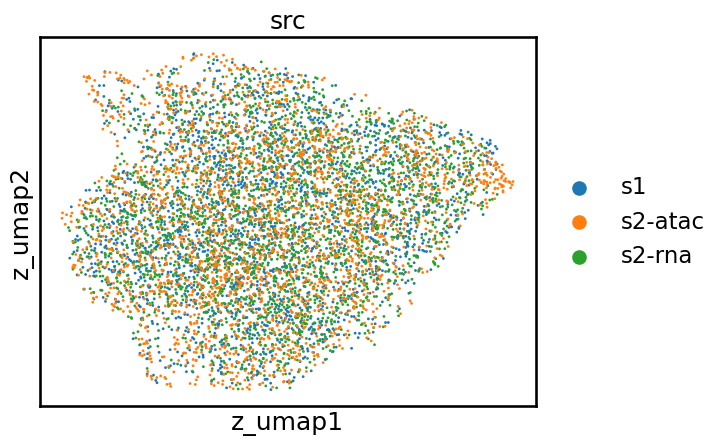

In [14]:
e, ep = 1, 2000
model_pt = 'sp_{:08d}'.format(ep-1)

tmp_dir = f'{result_dir}/MB_RNA_H3K27ac_modalMatch/e{e}/default/predict/{model_pt}'
target_ads = [ad_mult_rna, ad_rna, ad_atac]
for i in range(3):
    z, u = load_zu(join(tmp_dir, f'subset_{i}/z/joint'))
    target_ads[i].obsm['z'] = z
    target_ads[i].obsm['u'] = u
    
ad_mosaic = sc.concat(target_ads)
ad_mosaic = get_umap(ad_mosaic, ['z'])

wrap_warn_plot(ad_mosaic, 'z_umap', ['src'])

In [15]:
# lisi_res = eval_lisi(
#     ad_mosaic,
#     batch_keys=['src'],
#     label_keys = [],
#     use_rep='z', use_neighbors=False,
# )
# lisi_res['src_iLISI'][0]

In [16]:
from lisi_bridge import eval_bridge
eval_bridge(
        ad_rna, ad_atac,
        label_key=None,
        batch_key='Sample',
        use_rep='z',
        use_fosc=True, use_acc=False, use_score=True,
    )

FOSCTTM=0.19888
Match_score=0.00452


{'FOSCTTM': 0.19888416738194398, 'Match_score': 0.004522665751648938}

### batch corr

In [17]:
from batchCorr import HARMONY

ad_mosaic.obsm['z_har'] = HARMONY(pd.DataFrame(ad_mosaic.obsm['z']), ad_mosaic.obs['src'].to_list())
split_ob([ad_mult_rna, ad_rna, ad_atac], ad_mosaic, ob='obsm', key='z_har')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
Reach convergence after 7 iteration(s).


In [18]:
eval_bridge(
        ad_rna, ad_atac,
        label_key=None,
        batch_key='Sample',
        use_rep='z_har',
        use_fosc=True, use_acc=False, use_score=True,
    )

FOSCTTM=0.19854
Match_score=0.00438


{'FOSCTTM': 0.1985435426002932, 'Match_score': 0.004380170803309314}

## Vis

In [19]:
fig_dir = f'/disco_500t/xuhua/gitrepo/BridgeNorm/figures/MB_RNA+H3K27ac_modalMatch/midas'
os.makedirs(fig_dir, exist_ok=True)
df = pd.DataFrame(ad_mosaic.obsm['z'], index=ad_mosaic.obs_names.to_list())
# df['before_clust'] = ad_mosaic.obs['before_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb.csv'))

df = pd.DataFrame(ad_mosaic.obsm['z_har'], index=ad_mosaic.obs_names.to_list())
# df['after_clust'] = ad_mosaic.obs['after_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb_har.csv'))

In [20]:
1

1